In [2]:
import pandas as pd 
import numpy as np # linear algebra
import seaborn as sns # data visualization library  
import matplotlib.pyplot as plt
%matplotlib inline

# Description of this work package

In WP1, you already clean the data, and select the most relevant features. In this work package, the purpose is to develop a machine learning to detect the failed bearing with best performance. 
* Task 1: Design an experiment scheme which evaluates the performance of the developed model based on cross validation.
* Task 2: Develop a model to achieve the best failure detection performance on an individual measurement.
* Task 3: Develop a model to achieve the best failure detection performance on time-series data under variate working conditions.

# Task 1.

## Basic case: Do not consider time-series and treat each data point independently.
In a basic case, we can ignore the time-dependency in the data points and treat each data point as independent from its past and future. In this case, we can simply use cross validation to seperate the dataset, train a model and calculate the performance indicators on the test dataset. To consider the uncertainty in the data seperation, a simple way is to do a k-fold cross validation: the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the $k$ “folds”:
* A model is trained using 
* $k-1$ of the folds as training data;
* the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
The performance measure reported by $k$-fold cross-validation is then the average of the values computed in the loop.

Implementation of a $k$-fold cross validation can be easily implemented in sklearn using the cross_validate function by through the parameter "cv= " (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html). You can also find a demo below.

First, we read the data and perform some elementary cleaning and scaling. You should be able to refine this based on your results from WP1.

In [3]:
from utility import read_data
from sklearn import preprocessing

# Read the data.
file_name = 'Excel - Jeu de données 30min.xlsx'
df_data = read_data(file_name)

# Get the features and labels.
X = df_data.iloc[:, :12]
y = df_data['Label']

# Scale the parameters
X = pd.DataFrame(data=preprocessing.StandardScaler().fit_transform(X), columns=X.columns)

Here, we run a 5-fold cross validation on a basic logistic regression. The results will be saved in cv_scores. If you want to tune any hyper-parameters, you can define a classifier based on GridSearchCV function: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [4]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the classifier.
clf = LogisticRegression()
# clf = GridSearchCV(LogisticRegression(),
#                                  param_grid={'C': [0.1, 10.]},
#                                  cv=5,
#                                  refit=True)
# Run a five-fold cross validation.
results = cross_validate(clf, X, y, cv=5, 
                         scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True)
# Define a variable to save the scores of each cross validation run.
cv_scores = {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }
print(cv_scores)

{'Training Accuracy scores': array([0.91666667, 0.84027778, 0.73611111, 0.77777778, 0.75694444]), 'Mean Training Accuracy': 80.55555555555556, 'Training Precision scores': array([0.96875   , 0.92982456, 0.86956522, 0.91666667, 0.8627451 ]), 'Mean Training Precision': 0.909510308700139, 'Training Recall scores': array([0.86111111, 0.73611111, 0.55555556, 0.61111111, 0.61111111]), 'Mean Training Recall': 0.675, 'Training F1 scores': array([0.91176471, 0.82170543, 0.6779661 , 0.73333333, 0.71544715]), 'Mean Training F1 Score': 0.7720433443477471, 'Validation Accuracy scores': array([0.41666667, 0.69444444, 0.5       , 0.91666667, 1.        ]), 'Mean Validation Accuracy': 70.55555555555554, 'Validation Precision scores': array([0.        , 1.        , 0.        , 0.85714286, 1.        ]), 'Mean Validation Precision': 0.5714285714285714, 'Validation Recall scores': array([0.        , 0.38888889, 0.        , 1.        , 1.        ]), 'Mean Validation Recall': 0.47777777777777775, 'Validation

c:\Users\Zhiguo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1335: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can plot the different scores in each cross validation run, and compare the scores of training with testing in each run. This could help us detect any overfitting problem.

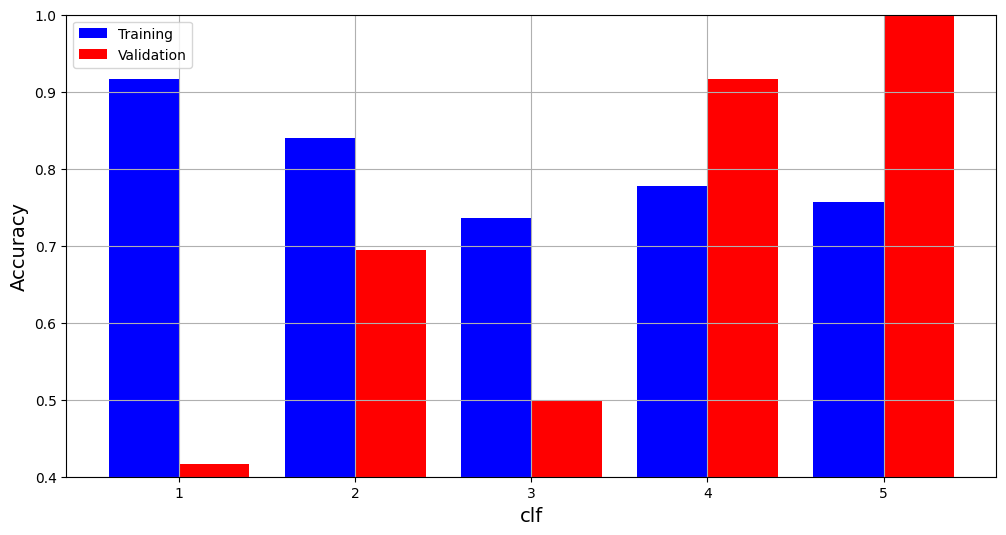

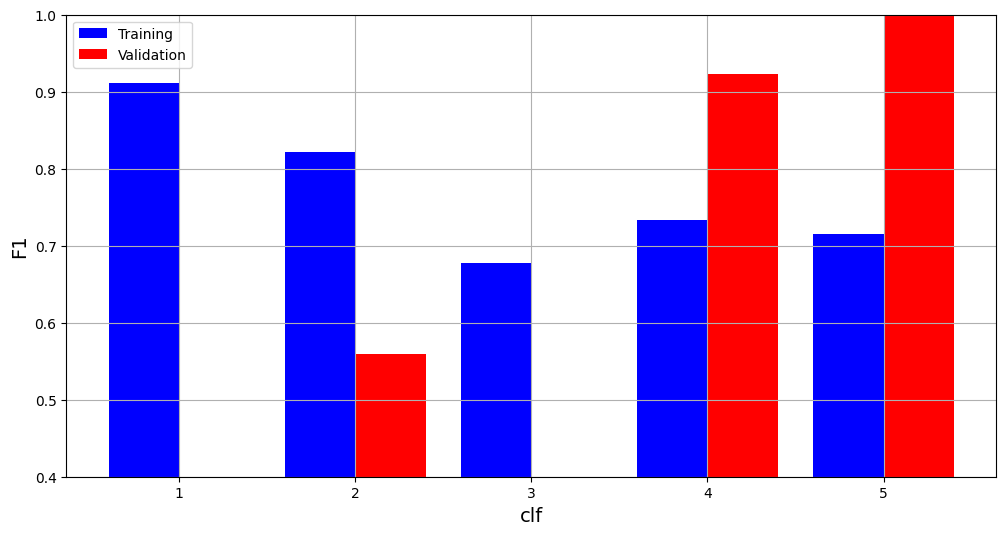

In [5]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_result: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = np.arange(len(train_data))+1
        X_axis = np.arange(len(train_data))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()


plot_result('clf',
            "Accuracy",
            "Accuracy scores in 5 Folds",
            cv_scores["Training Accuracy scores"],
            cv_scores["Validation Accuracy scores"])

plot_result('clf',
            "F1",
            "F1 scores in 5 Folds",
            cv_scores["Training F1 scores"],
            cv_scores["Validation F1 scores"])

Then, we can use the resulted scores in cv_scores to evaluate the performance of your developed model.

## To think:
The goal of running cross validation is to compare the performance of different models, so that we could anticipate the model will perform well when applied in practice. Hence, the test data generated by the cross validation scheme should be as close to the real application scenarios. In this project, the application scenario is to detect failures in the final testing data set, which behaves like this:
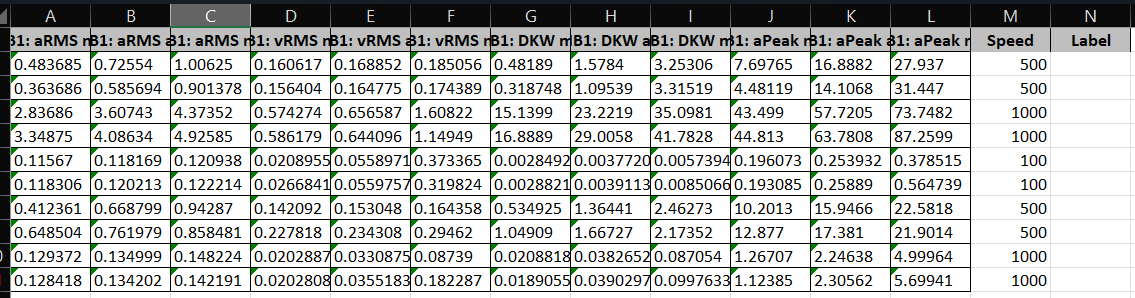

A significant feature of this dataset is that it is a time series with variate speed. Do you think the current cross validation scheme is sufficient to simulate this kind of operation condition? If not, you might consider improve the scheme. Otherwise, the developed model might not be able to generalize well in the final testing data set.

# Task 2.

Your task is, then, try to develop a model that have best performance on a single measurement. You can test the performance through the cross validation we discussed in Task 1. When you report your results, report the best model you find, as well as your cross validation scheme, and the performance metrics you get through the cross validation.

For the models you could try, except the models we introducted in the course, there are a variaty of models that are supported in sklearn: https://scikit-learn.org/stable/user_guide.html. You are encouraged to try other models as well (Both supervised learning and unsupervised learning models could be relevant).

# Task 3.

Your task is to develop a model for detecting failures in a time-series under variate working conditions. Then, you should apply this model to detect the failures in the final testing dataset. The waited results for this task is:
* For the time-series from the four bearing: Predict if each bearing fails;
* If some bearing fails, predict the failure happens from which time.